The practice model i'm building is here: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb

In [46]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

In [47]:
import torch
import sklearn
from sklearn.datasets import make_moons
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_STATE = 42

X, y = sklearn.datasets.make_moons(n_samples=1000, noise = 0.2, random_state = RANDOM_STATE)

In [48]:
X.shape, y.shape

((1000, 2), (1000,))

In [49]:
# Now lets try to visualize the data with a DataFrame

df = pd.DataFrame({"X1": X[:, 0],
                  "X2": X[:, 1],
                  "Y": y})

df.head(10)

,X1,X2,Y
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0
5,0.662510,-0.084356,1
6,0.274510,-0.189904,1
7,-0.115556,0.535912,1
8,1.572369,-0.335447,1
9,0.763990,0.962359,0


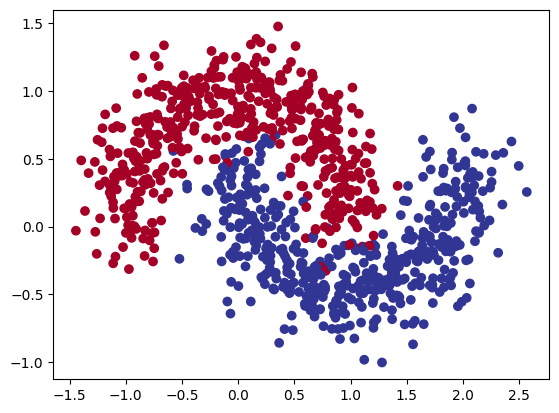

In [50]:
# Visualize the data on a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [51]:
# 1.1. Converting Data into PyTorch Tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [52]:
# 1.2 Split the data into training and test sets using train_test_split with 80% training and 20% testing.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

In [53]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [54]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()

    self.layer1 = nn.Linear(in_features = in_features, out_features = hidden_units)
    self.layer2 = nn.Linear(in_features = hidden_units, out_features = hidden_units)
    self.layer3 = nn.Linear(in_features = hidden_units, out_features = out_features)

    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = MoonModelV0(in_features = 2,
                      out_features = 1,
                      hidden_units = 10)

model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

# 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2

In [55]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

# 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

In [56]:
# Let's calculate the accuracy
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [59]:
torch.manual_seed = RANDOM_STATE
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)  # make sure both the sets are on same device
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## training
  model_0.train()

  # Do the forward pass (here we convert raw logits to prediction labels)
  y_logits = model_0(X_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_labels = torch.round(y_pred_probs)

  # Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_labels, y_train.int())

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ## testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.34 Acc: 0.85 | Test loss: 0.35 Test acc: 0.82
Epoch: 100 | Loss: 0.28 Acc: 0.87 | Test loss: 0.28 Test acc: 0.86
Epoch: 200 | Loss: 0.27 Acc: 0.88 | Test loss: 0.26 Test acc: 0.88
Epoch: 300 | Loss: 0.25 Acc: 0.89 | Test loss: 0.24 Test acc: 0.89
Epoch: 400 | Loss: 0.23 Acc: 0.90 | Test loss: 0.22 Test acc: 0.91
Epoch: 500 | Loss: 0.20 Acc: 0.91 | Test loss: 0.19 Test acc: 0.92
Epoch: 600 | Loss: 0.17 Acc: 0.93 | Test loss: 0.15 Test acc: 0.94
Epoch: 700 | Loss: 0.14 Acc: 0.95 | Test loss: 0.12 Test acc: 0.96
Epoch: 800 | Loss: 0.12 Acc: 0.96 | Test loss: 0.10 Test acc: 0.97
Epoch: 900 | Loss: 0.11 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98


# 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

(yup i copied this part couldn't get it for the life of me)

In [62]:
import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

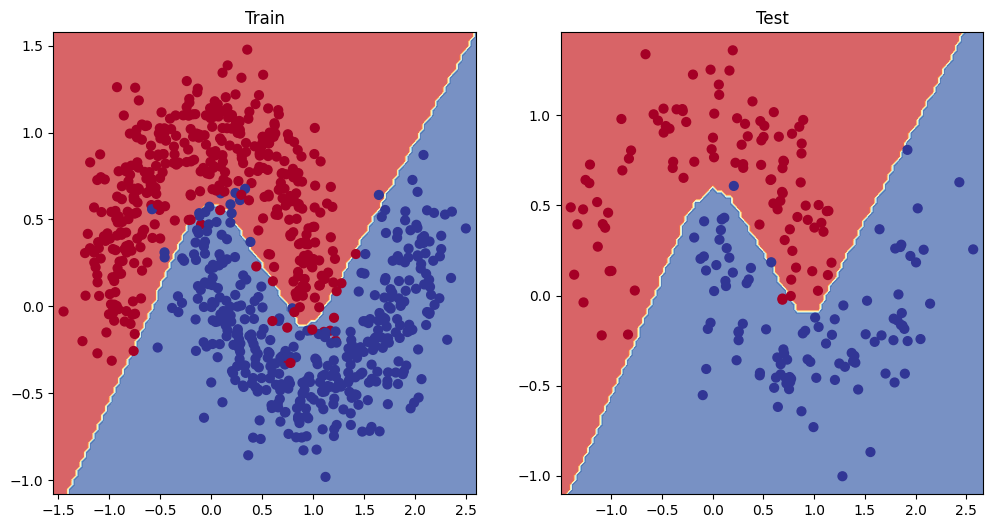

In [63]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

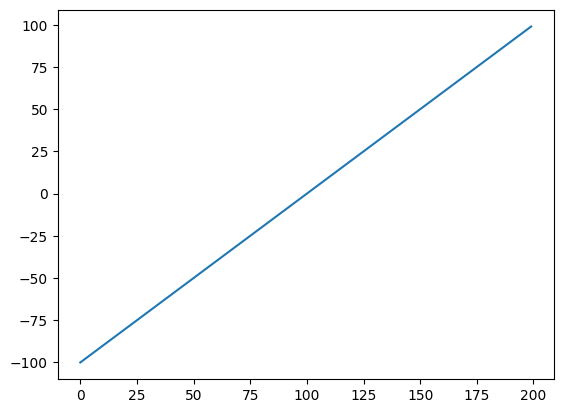

In [64]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)

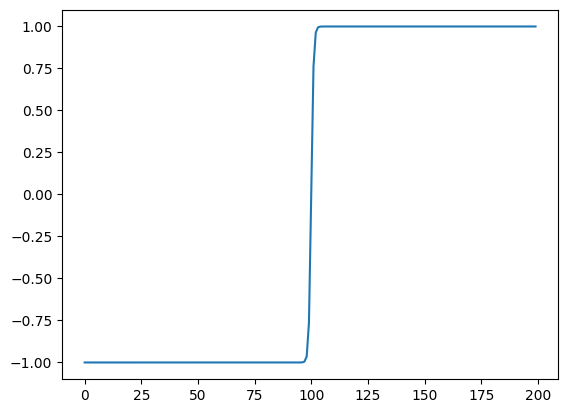

In [65]:
plt.plot(torch.tanh(tensor_A))

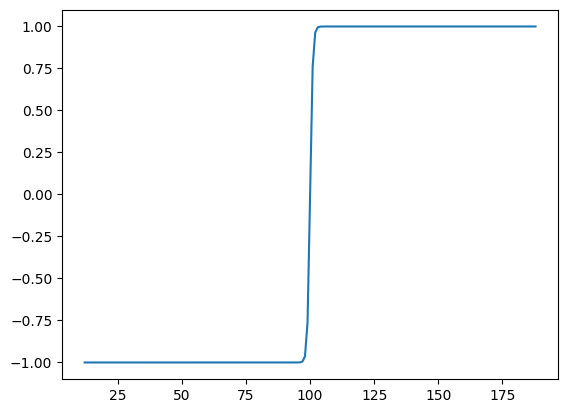

In [66]:
# Replicate torch.tanh() and plot it
def tanh(x):
  # Source - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))

# 7. Create a multi-class dataset using the spirals data creation function from CS231n

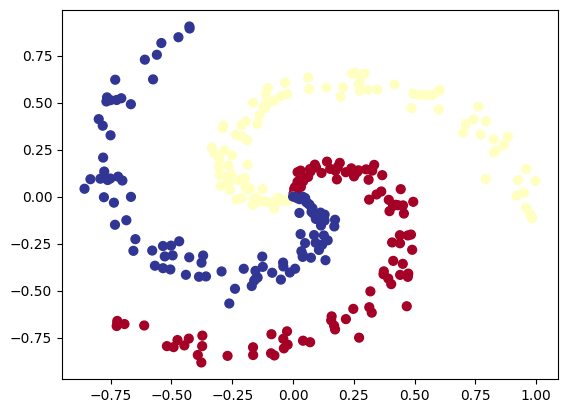

In [67]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [68]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)


(240, 60, 240, 60)

In [70]:
# Let's calculate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [71]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [72]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

torch.float32 torch.float32 torch.int64 torch.int64


In [73]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

In [74]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.11 Test acc: 0.37
Epoch: 100 | Loss: 0.07 Acc: 0.99 | Test loss: 0.04 Test acc: 1.00
Epoch: 200 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 300 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 400 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 500 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.02 Test acc: 0.98
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.02 Test acc: 0.98
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.03 Test acc: 0.98


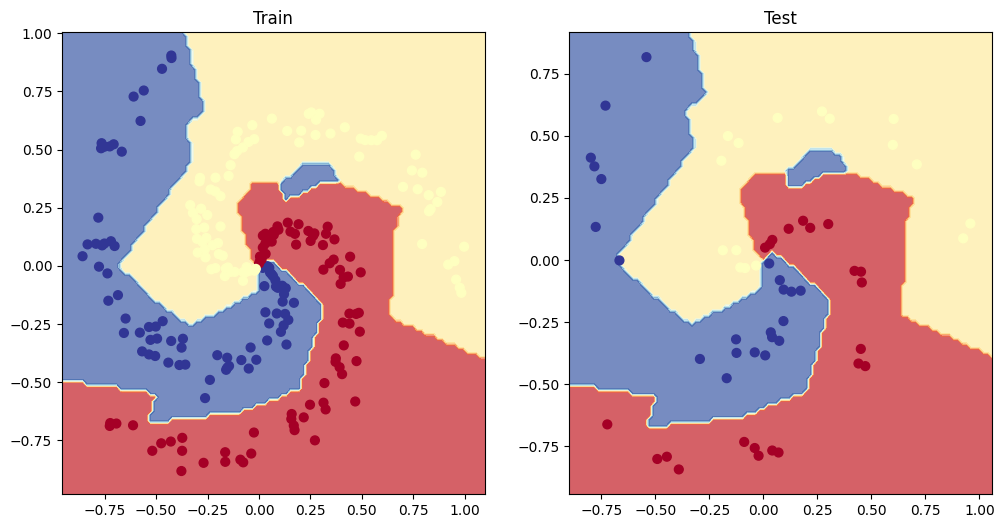

In [75]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)